# LSTM para prever Temperaturas de Dry Bulb

## Introdução

A temperatura de Dry Bulb, normalmente chamada de "temperatura do ar", é a propriedade do ar mais comumente utilizada.[1]

É chamada de "Dry Bulb" porque a temperatura do ar é indicada por um termômetro que não é afetado pela Umidade do ar. [1]

A temperatura de Dew Point é a temperatura em que o vampor de água começa a condensar no ar (a temperatura na qual o ar se torna completamente saturado).  Acima dessa temperatura, o orvalho começa a se formar.[1]

 - Se a temperatura de Dew-Point está próxima da temperatura do ar (Dry bulb temperature) - A umidade relativa é alta.
 - Se a temperatura de Dew-Point muito abaixo da temperatura do ar - A umidade relativa é baixa.

 
Quando a temperatura do Dry Bulb é reduzida ao Dew-Point, começam a se formar: nevoeiro, orvalho, geada, nuvens, chuva, granizo ou neve.[2]

Na aviação, a temperatura do Dry Bulb, juntamente com a temperatura do Dew-Point, permitem saber onde está a base da nuvem, pois a nuvem se forma justamente quando elas se equiparam.[2]

## Objetivo

Dado um dataset com vários informações relativas a vôos, organizados de forma sequencial no tempo (time series), a proposta desse notebook é prever um destes atributos considerados relevantes para a tomada de decisão do piloto (aumentar ou diminuir a altitude de vôo, por exemplo).

Tendo em vista a importância do conhecimento sobre a formação e posição de nuvens por parte dos pilotos, este notebook propõe uma arquitetura de Rede neural Recorrente utilizando Células LSTM para prever a temperatura do Dry Bulb, popularmente conhecida como temperatura do ar.

## Sumário

1. Importações
2. Aquisição, Limpeza e Tratamento do Dataset
3. Preparação dos dados de Treino e Teste
4. Modelo RNN
5. Treinamento
6. Resultados: Previsão em Relação ao Dataset de Teste
7. Avaliação do Modelo
8. Previsão dos próximos valores
9. Referências

## 1. Importações

In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from scipy.signal import correlate

In [4]:
import warnings

## 2. Aquisição, Limpeza e Tratamento do Dataset

### 2.1. Carregando o arquivo CSV em um Dataframe 

In [5]:
df = pd.read_csv('./data/QCLCD_PDX_20150901.csv')

### 2.2. Tratando os dados

In [6]:
### Adicionando zeros à coluna Time para que todos os valores tenham 4 algarismos:
df['Time'] = df['Time'].map(str).apply(lambda x: x.zfill(4))

### Juntando colunas Date e Time em uma só
df["Period"] = df["Date"].map(str) + str('-') +df["Time"].map(str)

### Transformando coluna Period em index e ordenando dataframe por ela:
df.set_index('Period',inplace=True)
df.sort_values(by='Period',inplace=True,ascending=True)

### Utilizando como atributo previsor apenas o 'DryBulbCelsius'
#df = df.filter(['DewPointCelsius' ],axis=1)
df = df.filter(['DryBulbCelsius' ],axis=1)


### Index do dataframe como série temporal:
df.index = pd.to_datetime(df.index)

### 2.3. Gráfico da Série Temporal

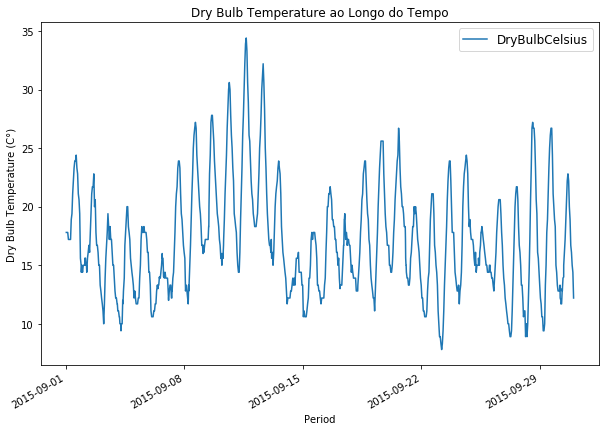

In [7]:
ax = df.plot(figsize=(10,7), title = 'Dry Bulb Temperature ao Longo do Tempo')
ax.set_ylabel('Dry Bulb Temperature (C°)')
ax.legend(loc='upper right', prop={'size':12})

## 3. Preparação dos Dados de Treino e Teste
A separação é feita retirando os *test_size* últimos valores do dataset original para teste. O restante para treino.

Essa divisão assim é feita por se tratar de uma série temporal, onde a ordem dos registros importa. Por esse motivo, não se utiliza o métodos como *train_test_split* do **scikit-learn**, já q este monta o dataset de test com amostras aleatórias do dataset original.

### 3.1. Separação do Dataset

In [8]:
test_size = 50 # Número de instâncias para teste

train_set = df.head(len(df)-test_size) #Dataset de treino

test_set = df.tail(test_size) #Dataset de teste



### 3.2. Colocando Dados na mesma Escala

In [9]:
normalizer = MinMaxScaler()
train_norm = normalizer.fit_transform(train_set)
test_norm = normalizer.transform(test_set)

### 3.3. Função para Criar Batches 

As entradas da rede serão sequências retiradas aleatoriamente do atributo previsor. As saídas da RNN também são sequências que serão avaliadas quando comparadas com o segundo retorno dessa função, que é a sequência de entrada deslocada de 1 registro para frente no tempo.

In [10]:
def next_batch(training_data, steps):
    """
    Essa função cria batches aleatórios.
    
    Argumentos:
    training_data : Set de treinamento. 
    steps : Dúmero de time steps.
    
    Retorna:
    x: x_batch. 
    y: y_batch .
 
    """
    
    #Índices iniciais aleatórios para o batch:
    rand_start = np.random.randint(0,len(training_data)-steps)
    
    #Indexar dados de rand_start até rand_start+steps+1
    batch = np.array(training_data[rand_start:rand_start+steps+1])
    batch = batch.reshape(1,steps+1) #
    
    #Batches em formato de tensor para serem utilizados pela RNN
    x = batch[:,:-1].reshape(-1,steps,1)
    y = batch[:,1:].reshape(-1,steps,1)
    
    #Retornas os batches 
    return x , y  # reshape(-1,steps,np.array(training_data).shape[1]) #


## 4. Modelo RNN



### 4.1. Parâmetros e Hiperparâmetros

In [11]:
num_inputs = np.array(df).shape[1] #número de atributos = 1

time_steps = 90 #tamanho das sequências de entrada

hidden_states = 100 #Número de hidden states das células LSTM

num_outputs = 1 #número de saídas da RNN

num_cells = 3 #número de células

learning_rate = 0.005 

epochs = 1000 # número de épocas

print_epochs = 100 # a cada quantas épocas o custo será printado

### 4.2. Placeholders

In [12]:
X_ph = tf.placeholder(tf.float32, [None,time_steps,num_inputs],name = 'x') # Placeholder com dimensões do tensor de entrada.

Y_ph = tf.placeholder(tf.float32, [None,time_steps,num_outputs],name = 'x') # Placeholder com dimensões do tensor de saída.

### 4.3. Estrutura da Rede

In [13]:
# Criação de 3 células LSTM
cell = [tf.contrib.rnn.LSTMCell(num_units = hidden_states, activation = tf.nn.tanh) for size in range(num_cells)]

# Criando camadas de células
multi_cell = tf.contrib.rnn.MultiRNNCell(cell) 

# Adicionando Dropout às entradas das células:
multi_cell = tf.contrib.rnn.DropoutWrapper(multi_cell, input_keep_prob=0.98)

#  Adicionando projeção de saída às células
multi_cell = tf.contrib.rnn.OutputProjectionWrapper(multi_cell, output_size = num_outputs)

### 4.4. Criação da RNN Especificada pela Estrutura Acima. 

In [14]:
outputs, states  = tf.nn.dynamic_rnn(multi_cell, X_ph ,dtype = tf.float32)

### 4.5. Loss Function e Otimização 

In [15]:
loss = tf.reduce_mean(tf.square(outputs-Y_ph)) # Loss = Mean Squared Error 

metric = tf.reduce_mean(tf.abs(outputs-Y_ph)) # MAE - somente para avaliação do modelo

In [16]:
def optimization(Optimizer, learning_rate, loss):
    """
    Essa função retorna um otimizador do tensor flow.
    
    Argumentos:
    Optimizer: Otimizador - Adam, RMSProp ou GradientDescent. 
    learning_rate: Valor usado como learning rate.
    loss: Loss function. 
    
    Retorna:
    opt: otimizador escolhido.
 
    """
    
    if Optimizer == 'RMSProp':
        opt = tf.train.RMSPropOptimizer(learning_rate = learning_rate).minimize(loss) #Utilização de RMSProp optimizer 
    elif Optimizer == 'GradientDescent':
        opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss) #Utilização de Adam optimizer
    else:
        opt = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss) #Utilização de Adam optimizer 
    return opt

In [17]:
 optimizer = optimization(Optimizer = 'Adam', learning_rate = learning_rate, loss = loss)

### 4.6. Inicialização das Variáveis Globais

In [18]:
start = tf.global_variables_initializer() 

### 4.7. Instância para Salvar Treinamento

In [19]:
saver = tf.train.Saver()

## 5. Treinamento

In [20]:
with tf.Session() as sess:
    sess.run(start) # Inicializa sessão
    mse_acum ,mae_acum = [],[]
    for epoch in range(epochs+1):
        X_batch, Y_batch = next_batch(train_norm, time_steps) #criando batch para treinamento
        
        sess.run(optimizer,feed_dict={X_ph: X_batch, Y_ph: Y_batch}) # Roda grafo de otimização dos pesos(minimização do Erro)
        
        #A cada 100 épocas:
        if epoch % print_epochs == 0:
            mse = loss.eval(feed_dict={X_ph: X_batch, Y_ph: Y_batch}) #Obtém MSE
            mae = metric.eval(feed_dict={X_ph: X_batch, Y_ph: Y_batch}) #Obtém MAE
            print(f'Época: {epoch} \t Mean Squared Error: {mse}\t Mean Absolut Error: {mae}')
            mse_acum.append(mse) #Acumula os valores de MSE em uma lista
            mae_acum.append(mae) #Acumula os valores de MAE em uma lista
            
    #salvando modelo para previsão futura
    saver.save(sess,"./lstm_model") # Salva a session para uso futuro

Época: 0 	 Mean Squared Error: 0.0769677385687828	 Mean Absolut Error: 0.23387667536735535
Época: 100 	 Mean Squared Error: 0.00428796699270606	 Mean Absolut Error: 0.05128760263323784
Época: 200 	 Mean Squared Error: 0.0015147707890719175	 Mean Absolut Error: 0.037139639258384705
Época: 300 	 Mean Squared Error: 0.0018948260694742203	 Mean Absolut Error: 0.03087466023862362
Época: 400 	 Mean Squared Error: 0.0018533602124080062	 Mean Absolut Error: 0.029690315946936607
Época: 500 	 Mean Squared Error: 0.0014497481752187014	 Mean Absolut Error: 0.03321688622236252
Época: 600 	 Mean Squared Error: 0.0007736642146483064	 Mean Absolut Error: 0.02818918228149414
Época: 700 	 Mean Squared Error: 0.0031036122236400843	 Mean Absolut Error: 0.026166539639234543
Época: 800 	 Mean Squared Error: 0.0012249198043718934	 Mean Absolut Error: 0.03274666145443916
Época: 900 	 Mean Squared Error: 0.0011088342871516943	 Mean Absolut Error: 0.024883387610316277
Época: 1000 	 Mean Squared Error: 0.0008495

## 6. Resultados: Previsão em Relação ao Dataset de Teste
 Para avaliar o modelo, é necessário uma base de comparação, que neste caso será o dataset de teste.

### 6.1. Sessão de Previsão

In [21]:
with tf.Session() as sess:
    #recuperando rnn salva com a instância saver
    saver.restore(sess,"./lstm_model")

    train_seed = list(train_norm[-time_steps:]) #Separando os últimos 'time_steps' valores de train_norm como batch inicial
    test_seed = list(test_norm)
    pred = []
    for i in range(test_size):  
        
        ### A entrada será sempre os últimos 'time_steps' valores de train_norm:
        X_batch = np.array(train_seed[-time_steps:]).reshape(1,time_steps,num_inputs) 
        ### Obtendo resultados das previsões
        Y_pred = sess.run(outputs, feed_dict={X_ph: X_batch})
        train_seed.append(test_seed[i])
        pred.append(Y_pred[0,-1,0])


INFO:tensorflow:Restoring parameters from ./lstm_model


### 6.2. Utilizar a Instância *normalizer* para "Desescalonar" o Resultado
É importante mencionar a necessidade de um reshape para que o resultado não seja mais um tensor de 3 dimensões e passe a ser um vetor.

In [22]:
results = normalizer.inverse_transform(np.array(pred).reshape(test_size,1))

### 6.3. Nova coluna no test_set com as previsões

In [23]:
warnings.filterwarnings("ignore") # Ignora warnings

test_set['Predicted'] = results # criação de uma nova coluna no test_set com as previsões

### 6.4. Gráfico do Valor Real e do Valor Previsto

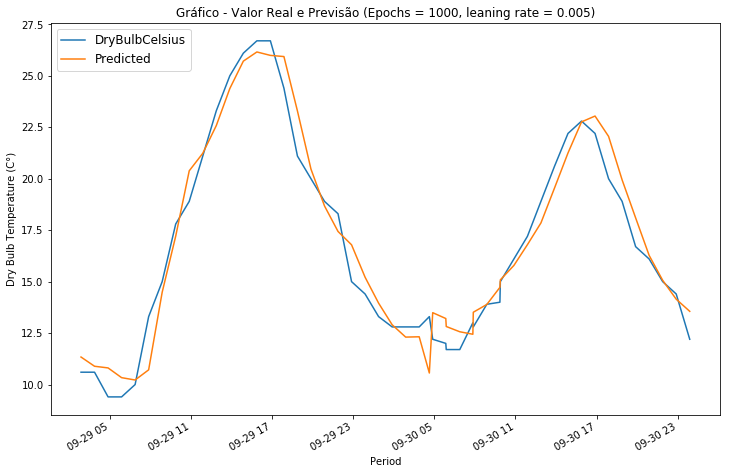

In [24]:
ax = test_set.plot(figsize=(12,8), title=f'Gráfico - Valor Real e Previsão (Epochs = {epochs}, leaning rate = {learning_rate})')
ax.set_ylabel('Dry Bulb Temperature (C°)')
ax.legend(loc='upper left', prop={'size':12})

In [25]:
test_set.tail() # Últimos valores de test_set

,DryBulbCelsius,Predicted
Period,,
2015-09-30 19:53:00,16.7,18.097672
2015-09-30 20:53:00,16.1,16.272919
2015-09-30 21:53:00,15.0,15.063868
2015-09-30 22:53:00,14.4,14.147092
2015-09-30 23:53:00,12.2,13.556877


## 7. Avaliação do Modelo
### 7.1. MSE e MAE ao Longo das Épocas 

É importante notar que essas medidas de erro são em cima de valores escalonados entre 0 e 1 dos atributos e classe.

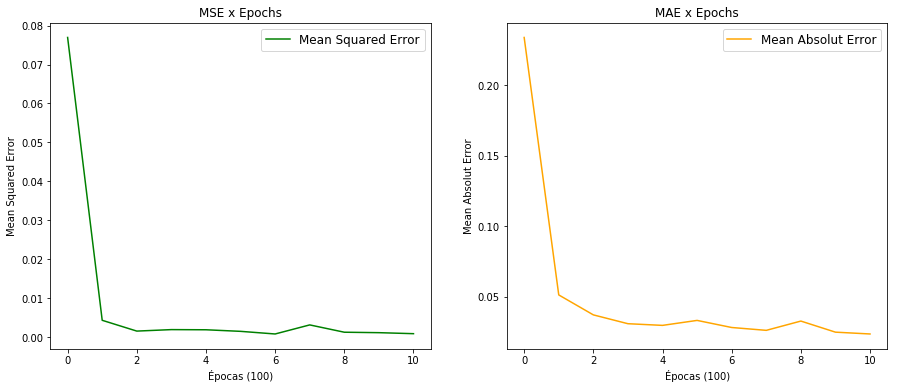

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mse_acum, color = 'green', label = 'Mean Squared Error')
ax[0].set_title('MSE x Epochs')
ax[0].set_ylabel('Mean Squared Error')
ax[0].set_xlabel('Épocas (100)')
ax[0].legend(loc=0,prop={'size':12})
ax[1].plot(mae_acum, color = 'orange', label = 'Mean Absolut Error')
ax[1].set_title('MAE x Epochs')
ax[1].set_ylabel('Mean Absolut Error')
ax[1].set_xlabel('Épocas (100)')
ax[1].legend(loc=0,prop={'size':12})


###  7.2. Mean Absolut Error (MAE) das Previsões

In [27]:
#mae = mean_absolute_error(test_set.DewPointCelsius,test_set.Predicted)
mae = mean_absolute_error(test_set.DryBulbCelsius,test_set.Predicted)

In [28]:
print(f' Mean Absolute Error = {mae:.5f} ')

 Mean Absolute Error = 0.83611 


###  7.3. Mean Squared Error (MSE) das Previsões

In [29]:
#mse = mean_squared_error(test_set.DewPointCelsius,test_set.Predicted)
mse = mean_squared_error(test_set.DryBulbCelsius,test_set.Predicted)

In [30]:
print(f' Mean Squared Error = {mse:.5f} ')

 Mean Squared Error = 1.10276 


###  7.4. Root Mean Squared Error (RMSE) das Previsões

In [31]:
#rmse = np.sqrt(mean_squared_error(test_set.DewPointCelsius,test_set.Predicted))
rmse = np.sqrt(mean_squared_error(test_set.DryBulbCelsius,test_set.Predicted))

In [32]:
print(f' Root Mean Squared Error = {rmse:.5f} ')

 Root Mean Squared Error = 1.05012 


### 7.5. R2-Score

R² é a medida estatística do quão próximos os dados estão da sua regressão linear.  [3]

Neste caso, percebe-se que a previsão e o valor real estão altamente correlacionados, o que **pode** indicar uma alta acurácia nas previsões.

Em geral, quanto maior o R², melhor é a representação dos dados pelo modelo gerado. Mas isso não é uma regra, pois essa métrica não consegue determinar se a regressão possui um bias, o que pode gerar a falsa impressão de que o modelo é uma boa representação dos dados. [4]

In [33]:
#r2 = r2_score(test_set.DewPointCelsius,test_set.Predicted)
r2 = r2_score(test_set.DryBulbCelsius,test_set.Predicted)

In [34]:
print(f' R² = {r2:.3f} ')

 R² = 0.952 


### 7.6. Correlograma com regressão entre Valor Real e Valor Previsto

Scatter Plot entre valor previsto e valor real, juntamente com a regressão linear, correlacionando os dois valores. As figuras na diagonal principal são as distribuições de cada variável. 

Observa-se que as previsões estão bastante correlacionadas com os valores reais. 

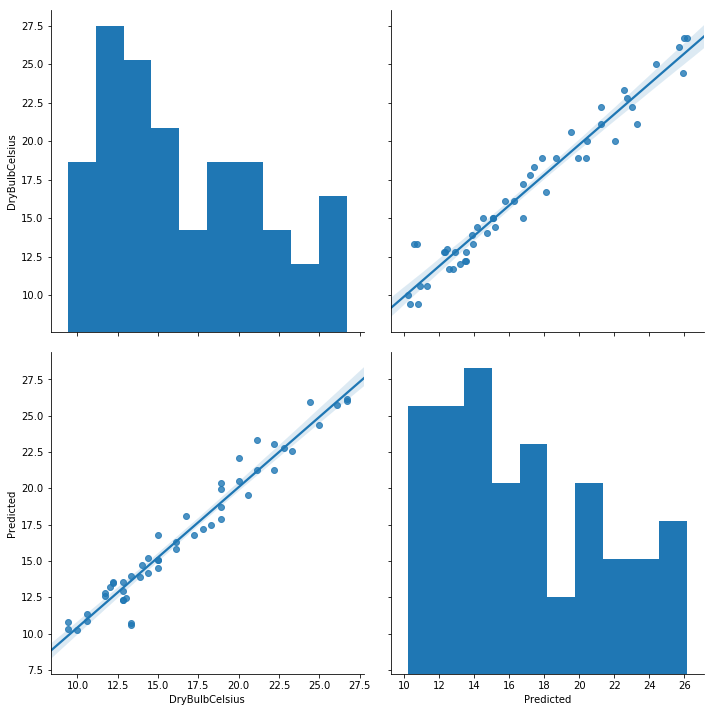

In [35]:
sns.pairplot(test_set,kind='reg',size = 5)


## 8. Previsão do Próximo Valor
### 8.1. Selecionando os Últimos Registros do Dataset e Normalizando-os

In [36]:
prediction_set  = df.tail(time_steps) #Dataset da previsão
prediction_norm = normalizer.transform(prediction_set) #Dataset da previsão escalonado

### 8.2. Prevendo a Próxima Dry Bulb Temperature (C°)

In [37]:
with tf.Session() as sess:
    #recuperando rnn salva com a instância saver
    saver.restore(sess,"./lstm_model")
    
    seed = list(prediction_norm) 
    X_batch = np.array(prediction_norm).reshape(1,time_steps,num_inputs)
    
    Y_future = sess.run(outputs, feed_dict={X_ph: X_batch})

INFO:tensorflow:Restoring parameters from ./lstm_model


### 8.3. "Desescalonando" Resultado

In [38]:
predict_future = normalizer.inverse_transform(Y_future.reshape(time_steps,1))
predict_future = float(predict_future[-1])

### 8.4. Próximo Valor da Temperatura :

In [39]:
print(f'DryBulbTemperature(t+1): {predict_future:.4f} °C')

DryBulbTemperature(t+1): 12.3899 °C


## 9. Referências

[1] Engineering ToolBox, (2004). Dry Bulb, Wet Bulb and Dew Point Temperatures. [online] Available at: https://bit.ly/2BbYgOD [Accessed 18 Feb. 2019]

[2] Flight Learnings. Temperature/Dew Point Relationship. Disponível em: https://bit.ly/2SZTP3y

[3] The Minitab Blog, (2013). Regression Analysis: "How Do I Interpret R-squared and Assess the Goodness-of-Fit?". [online] Disponível em: https://bit.ly/2pP83Eb

[4] The Minitab Blog, (2016). Five Reasons Why Your R-squared Can Be Too High. Disponível em: https://bit.ly/2l0FVsC

##### Bibliografia complementar:
- Bouktif, Salah & Fiaz, Ali & Ouni, Ali & Serhani, Mohamed. (2018). Optimal Deep Learning LSTM Model for Electric Load Forecasting using Feature Selection and Genetic Algorithm: Comparison with Machine Learning Approaches †. Energies. 11. 1636. 10.3390/en11071636. 

- Buck, Robert N. Weather Flying. New York: MacMillian, 1970